In [208]:
from importlib import reload
import dsp_utils as dsp
import plot_utils as plots
from matplotlib import pyplot as plt
from scipy import signal
import numpy as np


3.91e+06


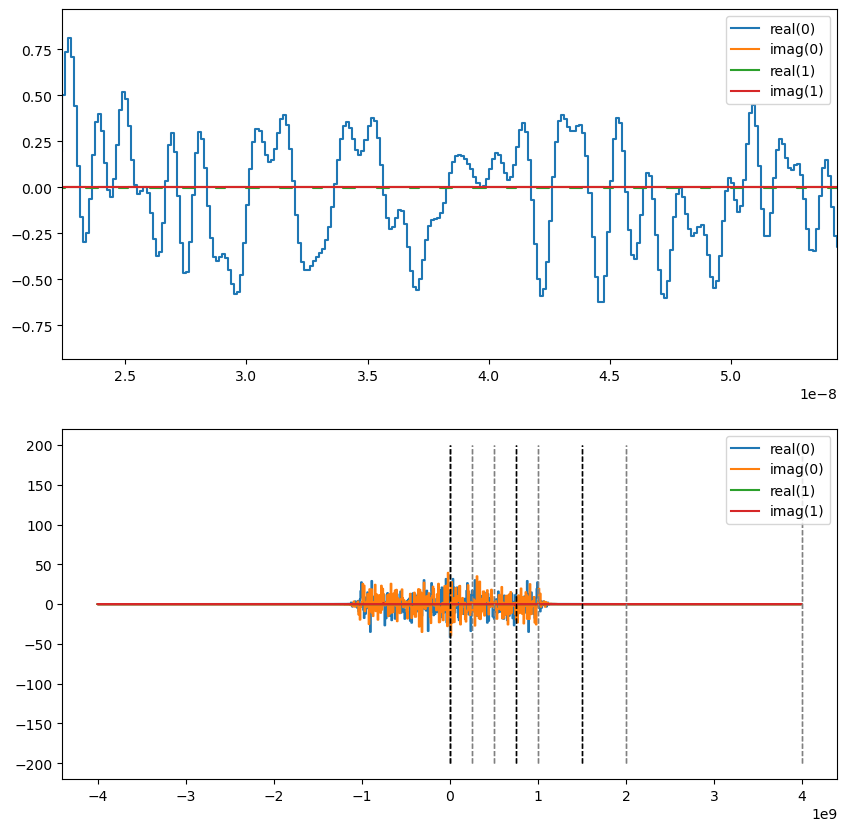

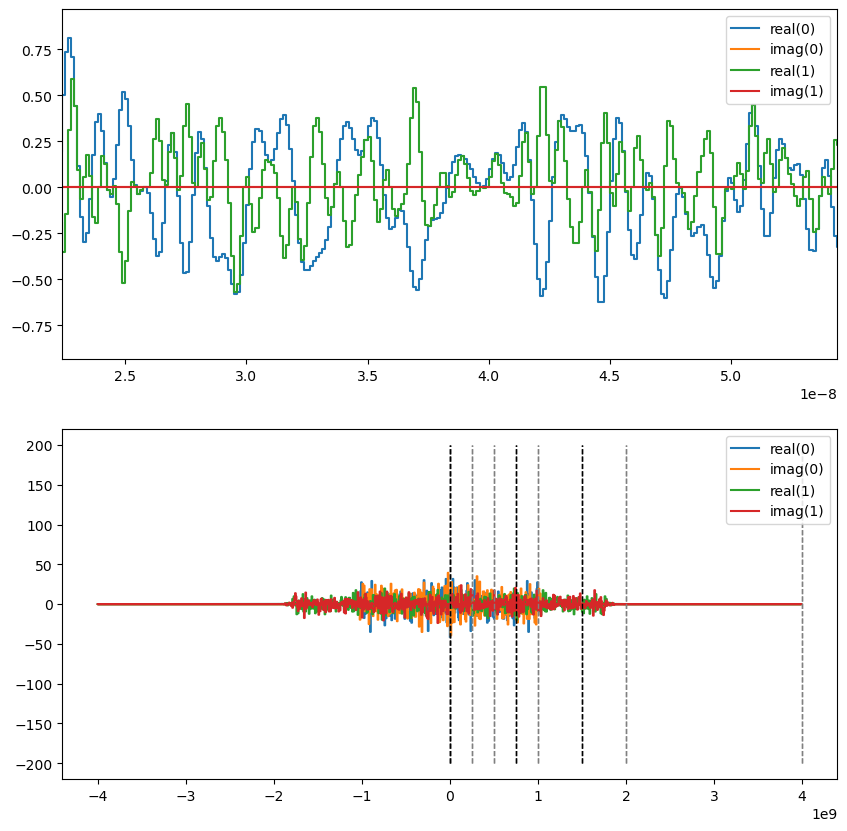

In [209]:
_ = [reload(_) for _ in [dsp, plots]]

n = 2**10
f_s = 2e9
print(f'{f_s / (n/2):.2e}')
os_factor = 4
f_s_u = f_s * os_factor
noise_raw = dsp.white_noise(n//os_factor)

# filt_bb = None
if (filt_bb is not None):
    noise = signal.lfilter(filt_bb, 1, noise_raw)
else:
    noise = noise_raw

# filt_bp = signal.butter(8, f_s / 2, btype='lowpass', output='sos', fs=f_s_u)
# filt_hp2 = signal.butter(1, f_s / 4, btype='lowpass', output='sos', fs=f_s_u)
# noise_filt = signal.sosfilt(filt_bp, noise)
# noise_filt = signal.sosfilt(filt_hp2, noise_filt)
# noise_filt = noise_filt.astype(np.complex128)
noise_filt_raw = signal.resample_poly(noise, os_factor, 1, window='hann')
# noise_filt_raw = lo_cos

filt_opt = None
if (filt_opt is not None):
    noise_filt = signal.lfilter(filt_opt, 1, noise_filt_raw)
else:
    noise_filt = noise_filt_raw

f_center = f_s * 3/8
t_range = np.linspace(0, n / f_s_u, n, endpoint=False)
lo_cos = np.cos(2 * np.pi * t_range * f_center).astype(np.complex128) # (np.exp(-1j*np.pi*f_s*t_range) + np.exp(1j*np.pi*f_s*t_range))/2
lo_sin = np.sin(2 * np.pi * t_range * f_center).astype(np.complex128) # 1j*(np.exp(-1j*np.pi*f_s*t_range) - np.exp(1j*np.pi*f_s*t_range))/2


def _(ax1, ax2, fig, **kwargs):
    center = n/f_s_u * 0.3
    rng = 256 / f_s_u
    # ax2.set_xscale('symlog')
    ax1.set_xlim(center - rng/2, center + rng/2)
    # ax2.set_xlim(-f_s, f_s)
    ax2.vlines((0, f_s, f_s/2, f_s/4, f_s/8, f_s_u/2), -200, 200, color='gray', ls='dashed', lw=1)
    ax2.vlines((0, f_center, f_center*2), -200, 200, color='black', ls='dashed', lw=1)
plots.signal_plot((noise_filt, lo_sin / 400), f_s_u, cb=_)
plots.signal_plot((noise_filt, noise_filt * lo_sin), f_s_u, cb=_)

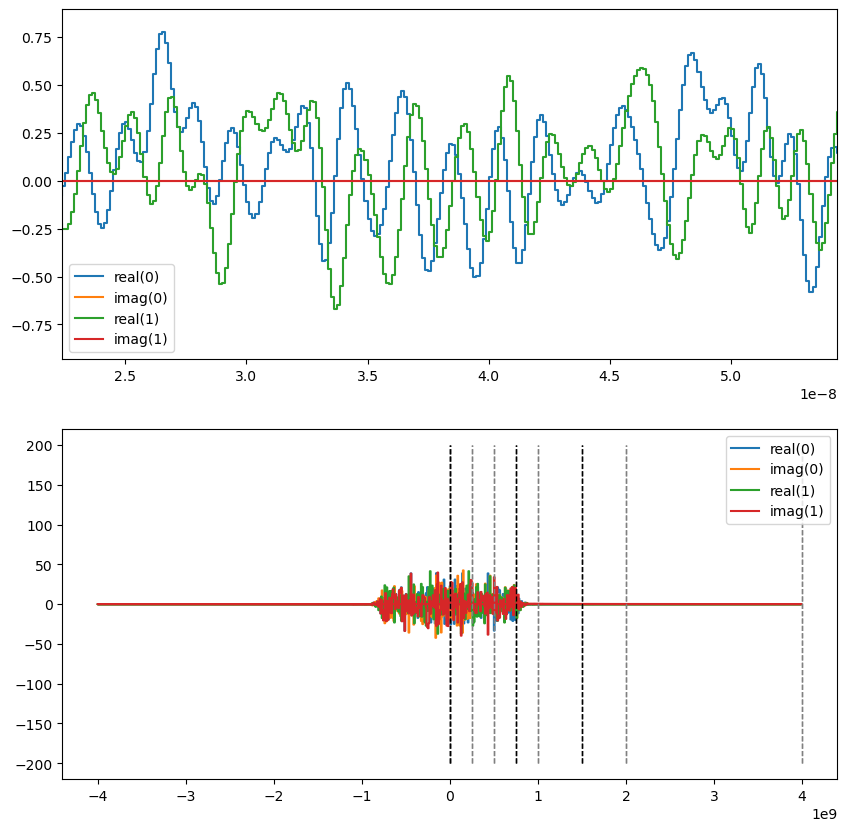

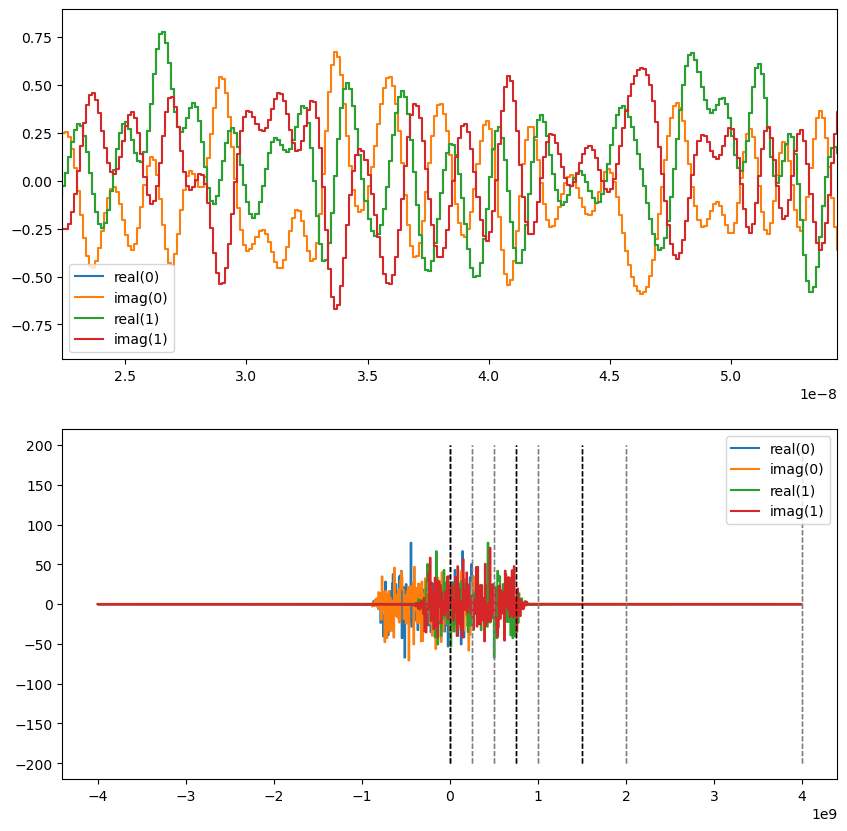

In [210]:
# noise_filt = rf
i = lo_cos * noise_filt
q = lo_sin * noise_filt

fir_lp = signal.firwin(64, f_center, window=('kaiser', os_factor), pass_zero='lowpass', scale=False, fs=f_s_u)
# lp_zero_c = signal.butter(8, f_center, btype='lowpass', output='sos', fs=f_s_u)
# i_filt = signal.sosfilt(lp_zero_c, i) * 2
# q_filt = signal.sosfilt(lp_zero_c, q) * 2
i_filt = signal.lfilter(fir_lp, 1, i) * 2
q_filt = signal.lfilter(fir_lp, 1, q) * 2

plots.signal_plot((i_filt, q_filt), f_s_u, cb=_)
plots.signal_plot((i_filt - 1j*q_filt, i_filt + 1j*q_filt), f_s_u, cb=_)

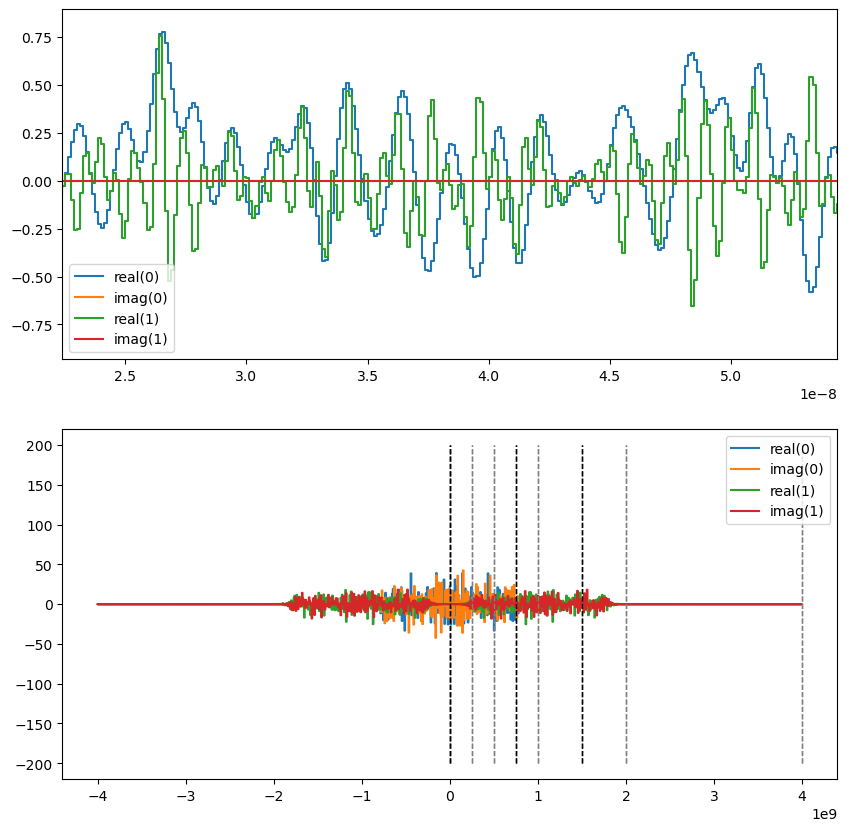

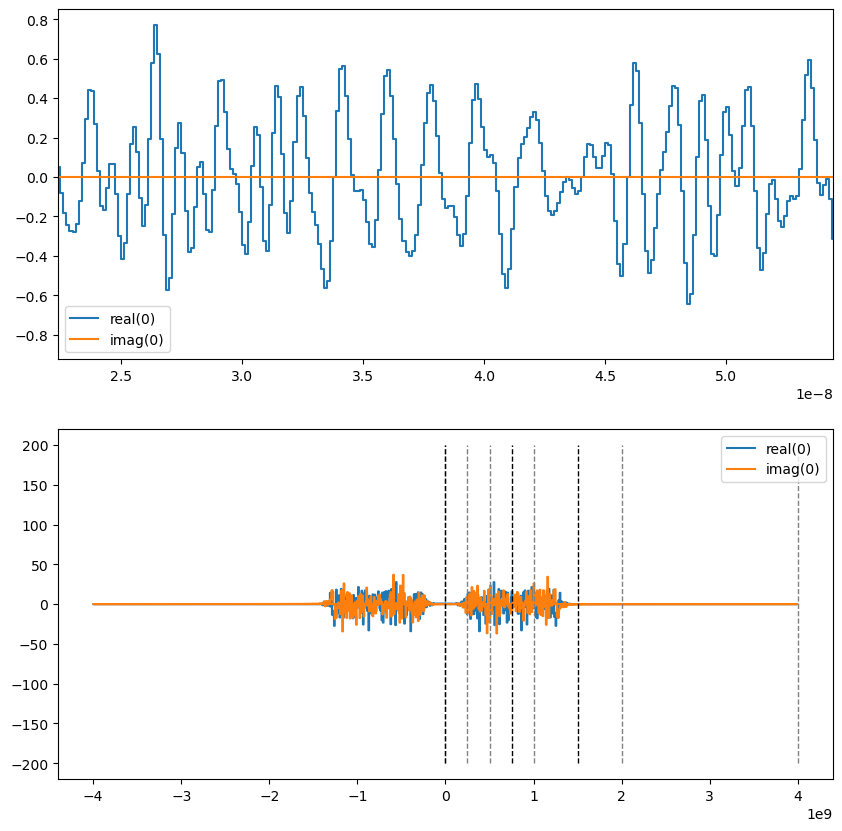

In [211]:
f_lo = 0.51 * f_s

rf_lo_cos = np.cos(2 * np.pi * t_range * f_lo)
rf_lo_sin = np.sin(2 * np.pi * t_range * f_lo)

i_rf = i_filt * rf_lo_cos
q_rf = q_filt * rf_lo_sin
rf = i_rf + q_rf # + dsp.white_noise(len(i_rf), 0, 0.05)

plots.signal_plot((i_filt, i_rf), f_s_u, cb=_)
# plots.signal_plot((q_filt, q_rf), f_s_u, cb=_)
plots.signal_plot(rf, f_s_u, cb=_)

3.0 128.0


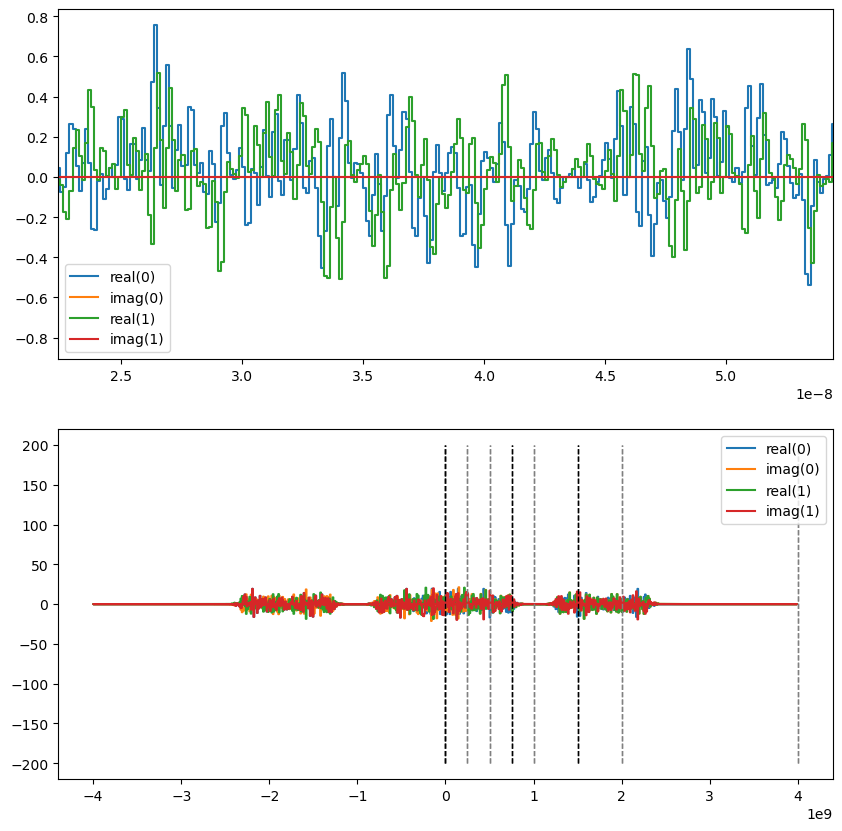

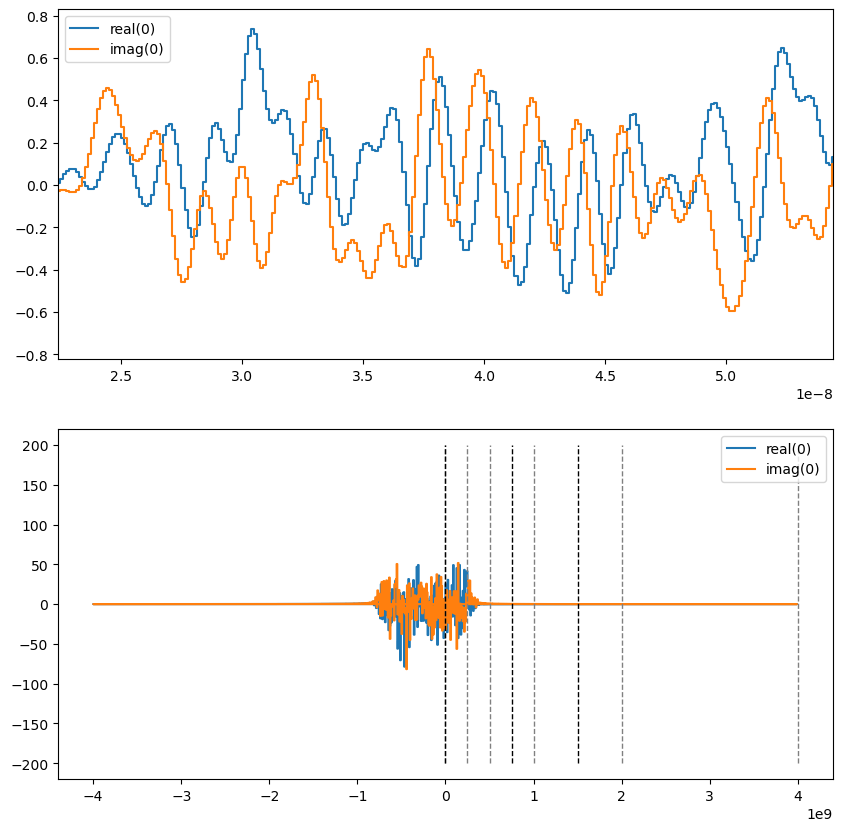

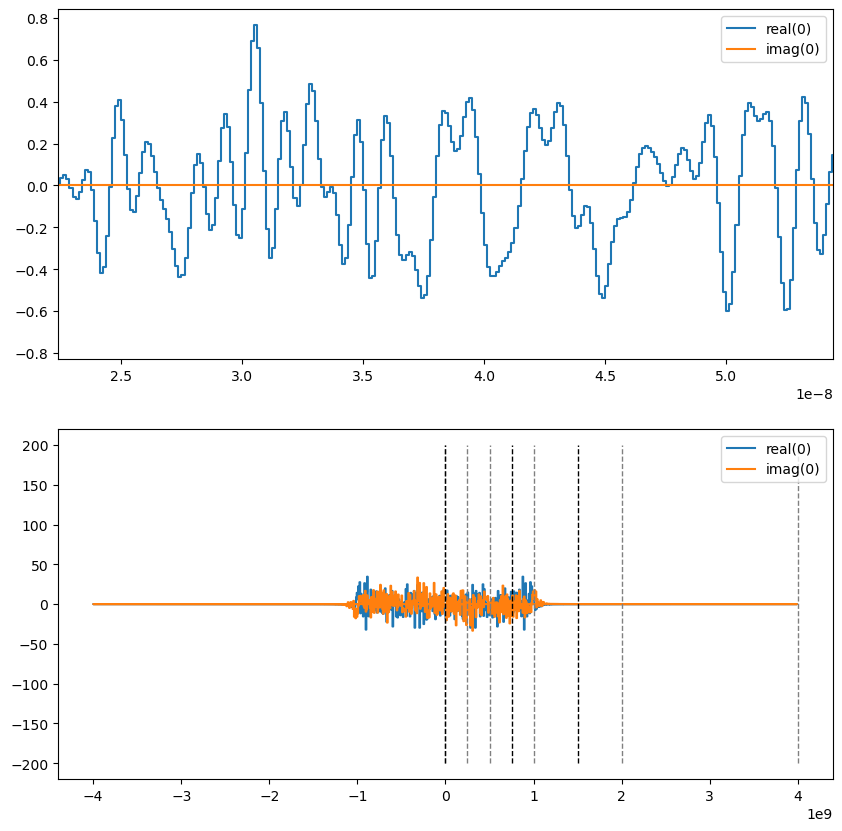

In [212]:
__ = [reload(x) for x in [dsp, plots]]
from math import lcm, gcd

i_if = rf * rf_lo_cos
q_if = rf * rf_lo_sin

# i_if_filt = signal.sosfilt(lp_zero_c, i_if) * 2
# q_if_filt = signal.sosfilt(lp_zero_c, q_if) * 2

i_if_filt = signal.lfilter(fir_lp, 1, i_if) * 2
q_if_filt = signal.lfilter(fir_lp, 1, q_if) * 2
a = lcm(int(f_s_u), int(f_center))
b = f_s_u / f_center
print(a / f_s_u, b * 12)
t_offset = -63/f_s_u
rcv_lo_cos = np.cos(2 * np.pi * f_center * (t_range + t_offset))
rcv_lo_sin = np.sin(2 * np.pi * f_center * (t_range + t_offset))
bb = rcv_lo_cos * i_if_filt + rcv_lo_sin * q_if_filt

plots.signal_plot((i_if, q_if), f_s_u, cb=_)
plots.signal_plot((i_if_filt - 1j*q_if_filt), f_s_u, cb=_)
plots.signal_plot(bb, f_s_u, cb=_)


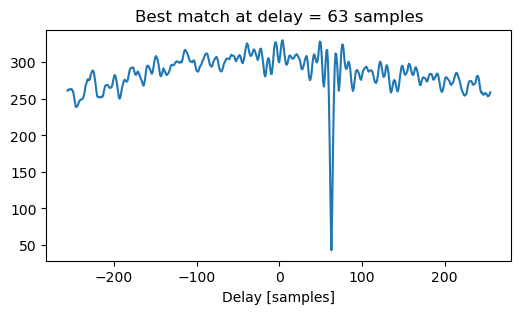

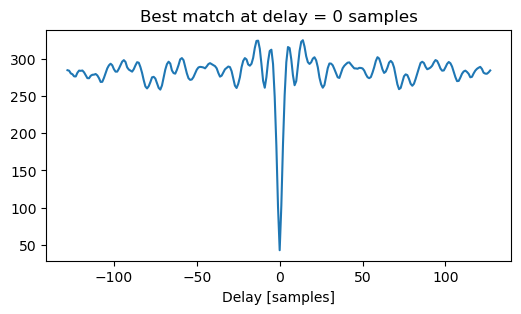

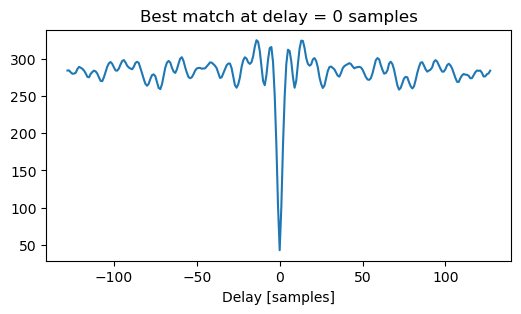

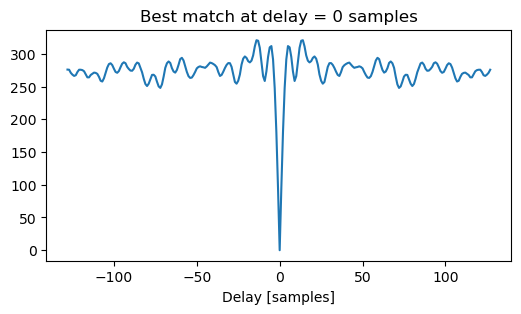

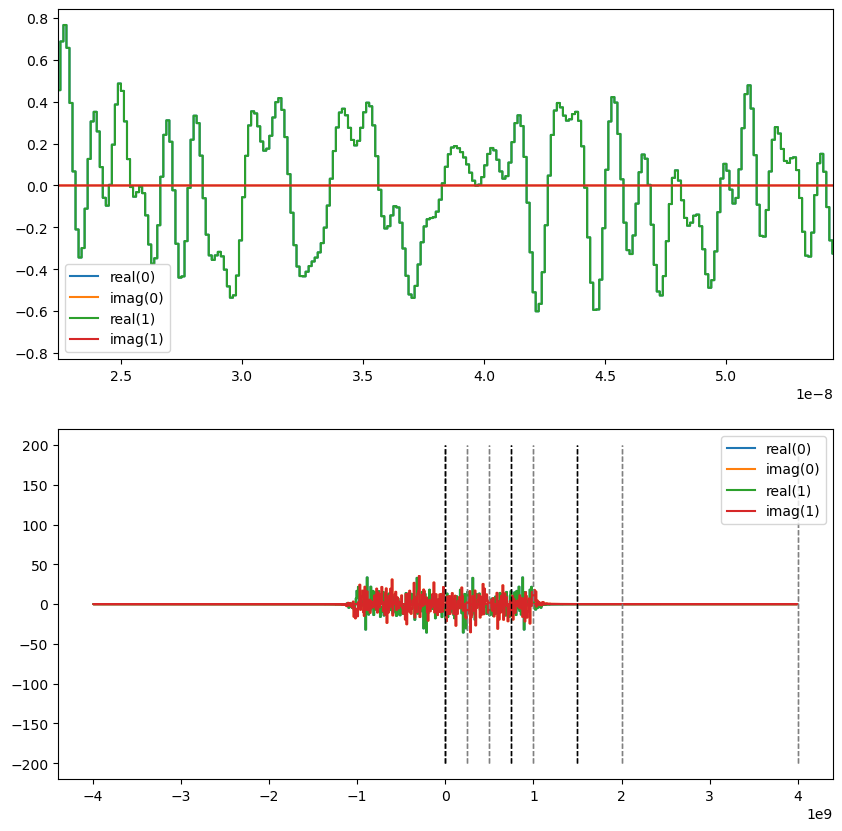

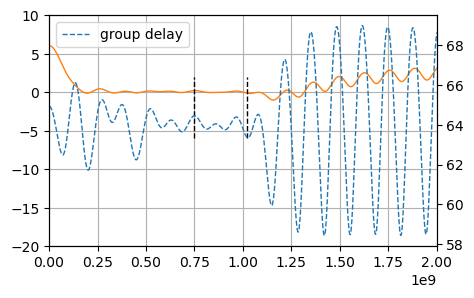

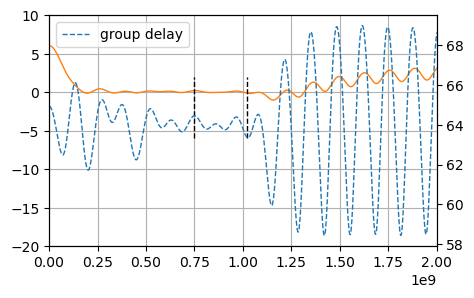

ENOB only preemph: 1.99+0.00j
ENOB more filt: 1.99+0.00j


In [213]:
__ = [reload(x) for x in [dsp, plots]]

tx, rx = noise_filt_raw, bb

rx, tx = dsp.find_delay(rx, tx, (-256, 256), True)
filt_opt_it = dsp.optimize_filter(tx, rx, 128, depth=20000)
if filt_opt is None:
    filt_opt = filt_opt_it

rx_filt = rx # signal.lfilter(filt_opt_it, 1, rx)
tx, rx_filt = dsp.find_delay(tx, rx_filt, (-128, 128), True)
rx, tx = dsp.find_delay(rx, tx, (-128, 128), True)
rx, rx_filt = dsp.find_delay(rx, rx_filt, (-128, 128), True)

plots.signal_plot((rx_filt, rx), f_s_u, cb=_)

def _2 (ax1, ax2, fig):
    ax1.set_xlim(0, f_s_u/4)
    ax1.set_ylim(-20, 10)
    ax1.vlines((f_center, f_lo), -6, 2, ls='dashed', lw=1, color='black')
plots.plot_filter(filt_opt, f_s_u, cb=_2)
plots.plot_filter(filt_opt_it, f_s_u, cb=_2)

print(f'ENOB only preemph: {dsp.enob(tx, rx):.2F}')
print(f'ENOB more filt: {dsp.enob(tx, rx_filt):.2F}')


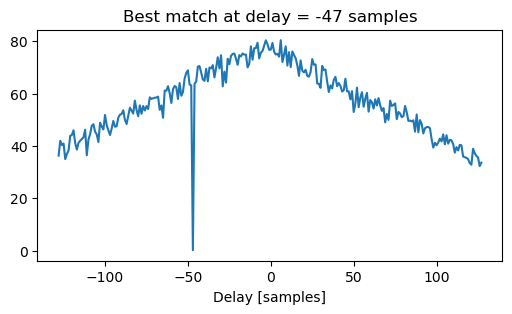

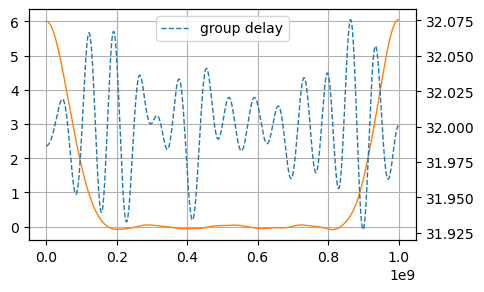

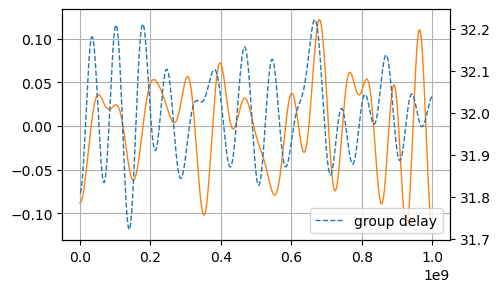

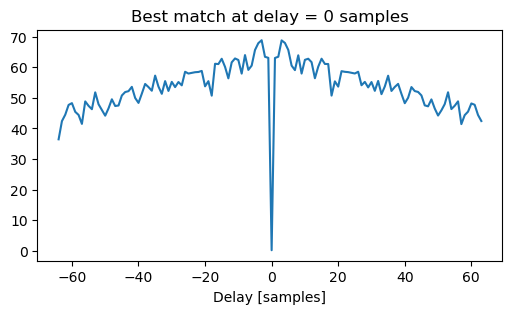

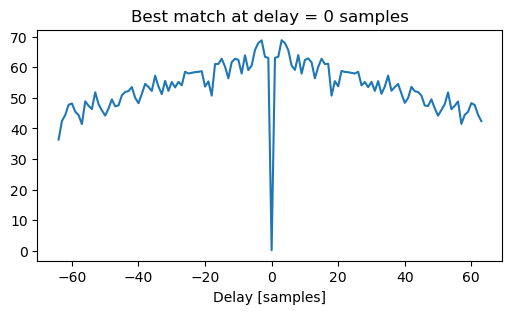

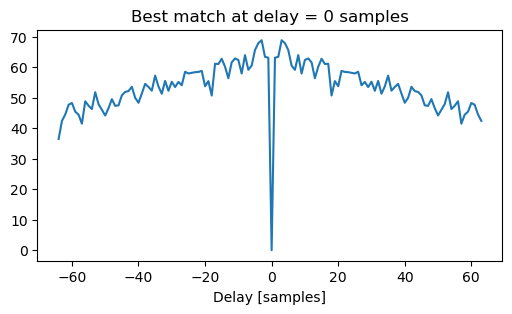

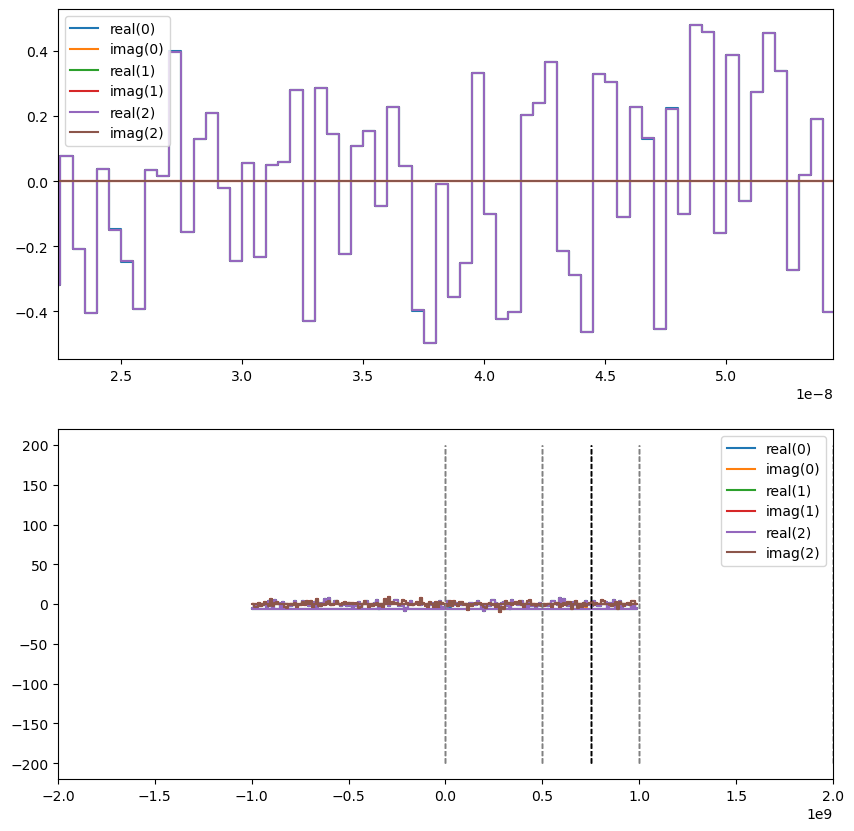

ENOB before filt: 5.671+0.000j
ENOB after filt: 5.671+0.000j


In [214]:

sig_downconv = signal.resample_poly(rx_filt, 1, os_factor)
tx_bb, rx_bb = dsp.find_delay(noise_raw, sig_downconv, (-128, 128), True)
# filt_bb_it = dsp.optimize_filter(tx_bb, rx_bb, 64, depth=20000)
# filt_bb = None
if filt_bb is None:
    filt_bb = filt_bb_it
plots.plot_filter(filt_bb, f_s)
plots.plot_filter(filt_bb_it, f_s)

rx_bb_filt = rx_bb # signal.lfilter(filt_bb_it, 1, rx_bb)
tx_bb, rx_bb_filt = dsp.find_delay(tx_bb, rx_bb_filt, (-64, 64), True)
rx_bb, tx_bb = dsp.find_delay(rx_bb, tx_bb, (-64, 64), True)
rx_bb, rx_bb_filt = dsp.find_delay(rx_bb, rx_bb_filt, (-64, 64), True)

def _3 (ax1, ax2, fig, **_):
    center = n/f_s_u * 0.3
    rng = 256 / f_s_u
    ax1.set_xlim(center - rng/2, center + rng/2)
    ax2.set_xlim(-f_s, f_s)
    ax2.vlines((0, f_s, f_s/2, f_s/4), -200, 200, color='gray', ls='dashed', lw=1)
    ax2.vlines((f_center), -200, 200, color='black', ls='dashed', lw=1)

plots.signal_plot((tx_bb, rx_bb, rx_bb_filt), f_s, cb=_3)

print(f'ENOB before filt: {dsp.enob(tx_bb, rx_bb):.3f}')
print(f'ENOB after filt: {dsp.enob(tx_bb, rx_bb_filt):.3f}')
